# CIS 419/519 
#**Homework 3 : Logistic Regression**

In [0]:
import pandas as pd
import numpy as np


### Logistic Regression

In [0]:
class LogisticRegression:

    def __init__(self, alpha = 0.01, regLambda=0.01, regNorm=2, epsilon=0.0001, maxNumIters = 100000, initTheta = None):       # maxIterNum = 10000   epsilon = 0.001 alpha = 0.01
        '''
        Constructor
        Arguments:
        	alpha is the learning rate
        	regLambda is the regularization parameter
        	regNorm is the type of regularization (either L1 or L2, denoted by a 1 or a 2)
        	epsilon is the convergence parameter
        	maxNumIters is the maximum number of iterations to run
          initTheta is the initial theta value. This is an optional argument
        '''
        self.alpha = alpha
        self.regLambda = regLambda
        self.regNorm = regNorm
        self.epsilon = epsilon
        self.maxNumIters = maxNumIters
        self.theta = initTheta  # give the initial theta to the theta
        self.X_train_mean = None  # mean value of standardization
        self.X_train_std = None   # standard deviation

    

    def computeCost(self, theta, X, y, regLambda):
        '''
        Computes the objective function
        Arguments:
            X is a n-by-d numpy matrix
            y is an n-by-1 numpy matrix
            regLambda is the scalar regularization constant
        Returns:
            a scalar value of the cost  ** make certain you're not returning a 1 x 1 matrix! **
        '''
        z = np.dot(X, theta)
        yhat = self.sigmoid(z)  # n-by-1 vector h_theta
        # the theta zero is not regularized, using L2 norm
        if self.regNorm == 1:   # 1st Norm for regularization
            Lreg = -1 * (np.dot(y.T, np.log(yhat)) + np.dot((1 - y).T, np.log(1-yhat))) + regLambda * (np.linalg.norm(theta[1:], ord=1))
        elif self.regNorm == 2: # 2nd Norm for regularization
            Lreg = -1 * (np.dot(y.T, np.log(yhat)) + np.dot((1 - y).T, np.log(1-yhat))) + regLambda * ((np.linalg.norm(theta[1:]))**2)
        else:
            print("regNorm is not defined")
        cost_value = Lreg.tolist()[0][0]    # convert the matrix to scalar
        return cost_value
    
    
    def computeGradient(self, theta, X, y, regLambda):
        '''
        Computes the gradient of the objective function
        Arguments:
            X is a n-by-d numpy matrix
            y is an n-by-1 numpy matrix
            regLambda is the scalar regularization constant
        Returns:
            the gradient, an d-dimensional vector
        '''
        n, d = X.shape      # theta is d shape
        z = np.dot(X, theta)
        yhat = self.sigmoid(z)  # n-by-1 vector h_theta
        gradient = np.zeros((d, 1))
        # extract the alpha outside of the gradient, and use different formula for gradient
        if self.regNorm == 1:  # L1
          gradient = np.dot(np.transpose(X), (yhat-y))      # the first row of X is 1
          gradient[1:] = gradient[1:] + regLambda * theta[1:]/np.absolute(theta[1:]) # regularization term
        elif self.regNorm == 2: #L2 
          gradient = np.dot(np.transpose(X), (yhat-y))      # the first row of X is 1
          gradient[1:] = gradient[1:] + regLambda * theta[1:] # regularization term
        return gradient    # include the negative into the gradient
    
    def hasConverged(self, theta_new, theta_old):
        '''
        Check if the gradient has converged/ L2 norm less than self.epsilon
        :param theta_new: new theta
        :param theta_old: old theta
        :return: True or False
        '''
        if np.linalg.norm(theta_old-theta_new) <= self.epsilon:
            # print('Has converged!')
            return True
        else:
            return False

    def gradientDescent(self, X, y, theta):     # the X should be preprocessed
        '''
        This function is for implementing the gradient descent to update the theta
        X: proprocessed n by d
        y: labels
        theta
        '''
        n, d = X.shape
        for iter in range(self.maxNumIters):
            theta_old = theta.copy()
            theta = theta - self.alpha*self.computeGradient(theta, X, y, self.regLambda)     # gradient is negative, +
            # print('Cost is: '+str(self.computeCost(theta, X, y, self.regLambda)))    # indicator of Cost value
            if iter > 0 and self.hasConverged(theta, theta_old) is True:
                print('logReg convergencd Iteration: ' + str(iter))
                print('Cost is: '+str(self.computeCost(theta, X, y, self.regLambda))) 
                break   # the gradient descent has converged
        return theta


    def fit(self, X, y):
        '''
        Trains the model
        Arguments:
            X is a n-by-d Pandas data frame
            y is an n-by-1 Pandas data frame
        Note:
            Don't assume that X contains the x_i0 = 1 constant feature.
            Standardization should be optionally done before fit() is called.
        '''
        # process the X set and standardization
        X_copy = X.copy().to_numpy()    # in case the new operation affects the original X, and convert df to np
        y_copy = y.copy().to_numpy()

        n = len(y)
        # self.X_train_mean = X_copy.mean(0)
        # self.X_train_std = X_copy.std(0)
        # X_scaled = (X_copy - X_copy.mean(0))/X_copy.std(0)
        X_fit = np.c_[np.ones((n, 1)), X_copy]  # add the first column

        n, d = X_fit.shape          # now the X has been added the first column
        y_fit = y_copy.reshape(n, 1)

        if self.theta is None:  # initialize the theta
            self.theta = np.matrix(np.random.rand(d, 1) - 0.5)    # why initial with random integer rather than zeros????

        # theta_copy = self.theta.copy()    # copy the theta (not sure if necessary)
        self.theta = self.gradientDescent(X_fit, y_fit, self.theta)


    def predict(self, X):
        '''
        Used the model to predict values for each instance in X
        Arguments:
            X is a n-by-d Pandas data frame
        Returns:
            an n-by-1 dimensional Pandas data frame of the predictions
        Note:
            Don't assume that X contains the x_i0 = 1 constant feature.
            Standardization should be optionally done before predict() is called.
        '''
        y_raw = self.predict_proba(X)
        y_pre = y_raw.iloc[:, 0].apply(lambda x: 1 if x >= 0.5 else 0)
        return y_pre

    def predict_proba(self, X):
        '''
        Used the model to predict the class probability for each instance in X
        Arguments:
            X is a n-by-d Pandas data frame
        Returns:
            an n-by-1 Pandas data frame of the class probabilities
        Note:
            Don't assume that X contains the x_i0 = 1 constant feature.
            Standardization should be optionally done before predict_proba() is called.
        '''
        X_copy = X.copy().to_numpy()
        n, d = X_copy.shape
        X_scaled = np.c_[np.ones((n, 1)), X_copy]
        return pd.DataFrame(self.sigmoid(X_scaled*self.theta))


    def sigmoid(self, Z):
      sigmoid = 1 / (1 + np.exp(-Z))
      return sigmoid



# Test Logistic Regression 1

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
logReg convergencd Iteration: 803
Cost is: 20.34985497519247


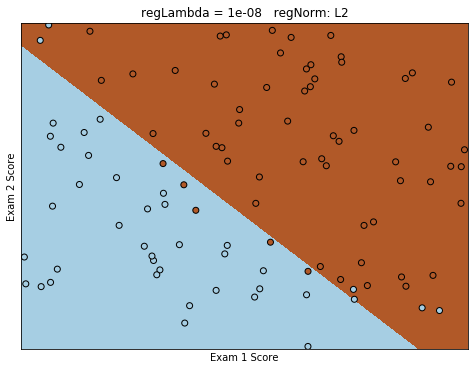

In [155]:
# Test script for training a logistic regressiom model
#
# This code should run successfully without changes if your implementation is correct
#
from numpy import loadtxt, ones, zeros, where
import numpy as np
from pylab import plot,legend,show,where,scatter,xlabel, ylabel,linspace,contour,title
import matplotlib.pyplot as plt
from google.colab import drive 
drive.mount('/content/gdrive')

def test_logreg1():
    # load the data
    filepath = "http://www.seas.upenn.edu/~cis519/spring2020/data/hw3-data1.csv"

    df = pd.read_csv(filepath, header=None)

    X = df[df.columns[0:2]]
    y = df[df.columns[2]]
    # print(X,y)
    n,d = X.shape
    # print('X shape:' + str(n)+str(d))

    # # Standardize features
    from sklearn.preprocessing import StandardScaler
    standardizer = StandardScaler()
    Xstandardized = pd.DataFrame(standardizer.fit_transform(X))  # compute mean and stdev on training set for standardization
    
    # train logistic regression
    regLambda_input = 1E-8
    regNorm_input=2
    logregModel = LogisticRegression(regLambda = regLambda_input, regNorm=regNorm_input)      # 1e-8 1e-2 1 2
    logregModel.fit(Xstandardized,y)
    
    # Plot the decision boundary
    h = .02  # step size in the mesh
    x_min = X[X.columns[0]].min() - .5
    x_max = X[X.columns[0]].max() + .5
    y_min = X[X.columns[1]].min() - .5
    y_max = X[X.columns[1]].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    allPoints = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    allPoints = pd.DataFrame(standardizer.transform(allPoints))
    Z = logregModel.predict(allPoints)
    Z = np.asmatrix(Z.to_numpy())

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot the training points
    plt.scatter(X[X.columns[0]], X[X.columns[1]], c=y.ravel(), edgecolors='k', cmap=plt.cm.Paired)
    
    # Configure the plot display
    plt.xlabel('Exam 1 Score')
    plt.ylabel('Exam 2 Score')
    plt.title('regLambda = '+ str(regLambda_input)+'   regNorm: L'+str(regNorm_input))

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    
    plt.show()
test_logreg1()

# Map Feature

In [0]:
def mapFeature(X, column1, column2, maxPower = 6):
    '''
    Maps the two specified input features to quadratic features. Does not standardize any features.
        
    Returns a new feature array with d features, comprising of
        X1, X2, X1 ** 2, X2 ** 2, X1*X2, X1*X2 ** 2, ... up to the maxPower polynomial
        
    Arguments:
        X is an n-by-d Pandas data frame, where d > 2
        column1 is the string specifying the column name corresponding to feature X1
        column2 is the string specifying the column name corresponding to feature X2
    Returns:
        an n-by-d2 Pandas data frame, where each row represents the original features augmented with the new features of the corresponding instance
        the first bias row is not added here
    '''
    X_1 = X[column1]   # the first column of the X, X1
    X_2 = X[column2]   # the second column of X, X2
    X_map = pd.concat([X_1,X_2], axis=1)    # define the new X
    for d in range(1, maxPower):
      for i in range(d+2): # 0, 1, 2, ..., d+1
        x_2_new = X_2.pow(i)    # axis 
        x_1_new = X_1.pow(d+1-i)
        new_col = x_1_new.multiply(x_2_new)
        X_map = pd.concat([X_map, new_col], axis=1)
    print(X_map)
    return X_map



# Test Logistic Regression 2

In [0]:
from numpy import loadtxt, ones, zeros, where
import numpy as np
from pylab import plot,legend,show,where,scatter,xlabel, ylabel,linspace,contour,title
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
def test_logreg2():

    polyPower = 6

    # load the data
    filepath = "http://www.seas.upenn.edu/~cis519/spring2020/data/hw3-data2.csv"
    df = pd.read_csv(filepath, header=None)

    X = df[df.columns[0:2]]
    y = df[df.columns[2]]

    n,d = X.shape

    # map features into a higher dimensional feature space
    Xaug = mapFeature(X.copy(), X.columns[0], X.columns[1], polyPower)

    # # Standardize features
    from sklearn.preprocessing import StandardScaler
    standardizer = StandardScaler()
    Xaug = pd.DataFrame(standardizer.fit_transform(Xaug))  # compute mean and stdev on training set for standardization
    
    # train logistic regression
    logregModel = LogisticRegressionAdagrad(regLambda = 0.00000001, regNorm=2)      # this line is changed for testing 1e-8 1e-2 1 2
    logregModel.fit(Xaug,y)
    
    # Plot the decision boundary
    h = .02  # step size in the mesh
    x_min = X[X.columns[0]].min() - .5
    x_max = X[X.columns[0]].max() + .5
    y_min = X[X.columns[1]].min() - .5
    y_max = X[X.columns[1]].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    allPoints = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    allPoints = mapFeature(allPoints, allPoints.columns[0], allPoints.columns[1], polyPower)
    allPoints = pd.DataFrame(standardizer.transform(allPoints))
    Xaug = pd.DataFrame(standardizer.fit_transform(Xaug))  # standardize data
    
    Z = logregModel.predict(allPoints)
    Z = np.asmatrix(Z.to_numpy())

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot the training points
    plt.scatter(X[X.columns[0]], X[X.columns[1]], c=y.ravel(), edgecolors='k', cmap=plt.cm.Paired)
    
    # Configure the plot display
    plt.xlabel('Microchip Test 1')
    plt.ylabel('Microchip Test 2')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    
    plt.show()


    print(str(Z.min()) + " " + str(Z.max()))

test_logreg2()

NameError: ignored

# Logistic Regression with Adagrad

In [0]:
class LogisticRegressionAdagrad:

    def __init__(self, alpha = 0.01, regLambda=0.01, regNorm=2, epsilon=0.0001, maxNumIters = 10000, initTheta = None):     # e = 1e-4
        '''
        Constructor
        Arguments:
        	alpha is the learning rate
        	regLambda is the regularization parameter
        	regNorm is the type of regularization (either L1 or L2, denoted by a 1 or a 2)
        	epsilon is the convergence parameter
        	maxNumIters is the maximum number of iterations to run
          initTheta is the initial theta value. This is an optional argument
        '''
        self.alpha = alpha
        self.regLambda = regLambda
        self.regNorm = regNorm
        self.epsilon = epsilon
        self.maxNumIters = maxNumIters
        self.theta = initTheta  # give the initial theta to the theta
        self.X_train_mean = None  # mean value of standardization
        self.X_train_std = None   # standard deviation
    

    def computeCost(self, theta, X, y, regLambda):
        '''
        Computes the objective function
        Arguments:
            X is a n-by-d numpy matrix
            y is an n-by-1 numpy matrix
            regLambda is the scalar regularization constant
        Returns:
            a scalar value of the cost  ** make certain you're not returning a 1 x 1 matrix! **
        '''
        z = np.dot(X, theta)
        yhat = self.sigmoid(z)  # n-by-1 vector h_theta
        # the theta zero is not regularized, using L2 norm
        if self.regNorm == 1:   # 1st Norm for regularization
            Lreg = -1 * (np.dot(y.T, np.log(yhat)) + np.dot((1 - y).T, np.log(1-yhat))) + regLambda * (np.linalg.norm(theta[1:], ord=1))
        elif self.regNorm == 2: # 2nd Norm for regularization
            Lreg = -1 * (np.dot(y.T, np.log(yhat)) + np.dot((1 - y).T, np.log(1-yhat))) + regLambda * ((np.linalg.norm(theta[1:]))**2)
        else:
            print("regNorm is not defined")
        cost_value = Lreg.tolist()[0][0]    # convert the matrix to scalar
        return cost_value
    
    
    def computeGradient(self, theta, X, y, regLambda):
        '''
        Computes the gradient of the objective function
        Arguments:
            X is a n-by-d numpy matrix
            y is an n-by-1 numpy matrix
            regLambda is the scalar regularization constant
        Returns:
            the gradient, an d-dimensional vector
        '''
        X_copy = X.copy()
        d = len(X_copy)      # theta is d shape d=1 now
        X_copy = X_copy.reshape((1, d))   # (n,) to (n,1)
        z = np.dot(X_copy, theta)
        yhat = self.sigmoid(z)  # one value
        gradient = np.zeros((d, 1))
        # extract the alpha outside of the gradient, and use different formula for gradient
        if self.regNorm == 1:  # L1
          gradient = np.dot(X_copy.T, (yhat-y))      # the first row of X is 1
          gradient[1:] = gradient[1:] + regLambda * theta[1:]/np.absolute(theta[1:]) # regularization term
        elif self.regNorm == 2: #L2 
          gradient = np.dot(X_copy.T, (yhat-y))      # the first row of X is 1
          gradient[1:] = gradient[1:] + regLambda * theta[1:] # regularization term
        return gradient    # include the negative into the gradient
    
    def hasConverged(self, theta_new, theta_old):
        '''
        Check if the gradient has converged/ L2 norm less than self.epsilon
        :param theta_new: new theta
        :param theta_old: old theta
        :return: True or False
        '''
        if np.linalg.norm(theta_old-theta_new) <= self.epsilon:
            # print('Has converged!')
            return True
        else:
            return False

    def gradientDescent(self, X, y, theta):     # the X should be preprocessed
        '''
        This function is for implementing the gradient descent to update the theta
        X: proprocessed n by d
        y: labels
        theta
        '''
        n, d = X.shape
        X_copy = X.copy()
        y_copy = y.copy()
        dataset = np.concatenate((X_copy, y_copy), axis=1)   # combine the X and y for shuffling
        G = np.zeros((d,1))
        min_const = 1E-5

        iter_break = 0            # flag of outer 

        for iter in range(self.maxNumIters):
            # dataset = np.concatenate((X_copy, y_copy), axis=1)   # combine the X and y for shuffling
            np.random.shuffle(dataset)  # shuffle the dataset for every outter iteration  # shuffle function
            y_shuffled = dataset[:, -1]  # separate the last column as y numpy.array
            X_shuffled = dataset[:, 0:-1]  # drop the y column
            theta_old = theta.copy()  # store the old theta of last outter iteration
            g = np.zeros((d, 1))    # store the gradient
            for ins_num in range(n):  # instance n is number of instances
                x_temp = X_shuffled[ins_num, :]
                y_temp = y_shuffled[ins_num]
                curr_grad = self.computeGradient(theta, x_temp, y_temp, self.regLambda)  # a vector
                g = np.power(curr_grad, 2)    # get the g as gradient's square
                
                G += g                # accumulate the g to G   d,1 vector
                curr_alpha = self.alpha / (np.sqrt(G) + min_const)    # curr_alpah is d*1 vector
                theta = theta - np.multiply(curr_alpha, curr_grad)   # curr_grad d*1 compGrad d*1

                # if iter > 0 and self.hasConverged(theta, theta_old) is True:
                #     iter_break = 1 
                #     break
            
            # if iter_break == 1:
            #     break

            # G += g
            # curr_alpha = self.alpha / (np.linalg.norm(G, 2) + min_const)
            # theta = theta - curr_alpha * self.computeGradient(theta, x_temp, y_temp, self.regLambda)

            # print('==============\nCurrent Iter is:' + str(iter + 1))  # print the iter number
            # print('Cost: '+str(self.computeCost(theta, X_shuffled, y_shuffled, self.regLambda)))

            if iter > 0 and self.hasConverged(theta, theta_old) is True:
                print('Adagrad converged Iteration:'+str(iter))
                break


        return theta


    def fit(self, X, y):
        '''
        Trains the model
        Arguments:
            X is a n-by-d Pandas data frame
            y is an n-by-1 Pandas data frame
        Note:
            Don't assume that X contains the x_i0 = 1 constant feature.
            Standardization should be optionally done before fit() is called.
        '''
        # process the X set and standardization
        X_copy = X.copy().to_numpy()    # in case the new operation affects the original X, and convert df to np
        y_copy = y.copy().to_numpy()

        n = len(y)
        # self.X_train_mean = X_copy.mean(0)
        # self.X_train_std = X_copy.std(0)
        # X_scaled = (X_copy - X_copy.mean(0))/X_copy.std(0)
        X_fit = np.c_[np.ones((n, 1)), X_copy]  # add the first column

        n, d = X_fit.shape          # now the X has been added the first column
        y_fit = y_copy.reshape(n, 1)

        if self.theta is None:  # initialize the theta
            self.theta = np.matrix(np.random.rand(d, 1) - 0.5)    # why initial with random integer rather than zeros????

        # theta_copy = self.theta.copy()    # copy the theta (not sure if necessary)
        self.theta = self.gradientDescent(X_fit, y_fit, self.theta)


    def predict(self, X):
        '''
        Used the model to predict values for each instance in X
        Arguments:
            X is a n-by-d Pandas data frame
        Returns:
            an n-by-1 dimensional Pandas data frame of the predictions
        Note:
            Don't assume that X contains the x_i0 = 1 constant feature.
            Standardization should be optionally done before predict() is called.
        '''
        y_raw = self.predict_proba(X)
        y_pre = y_raw.iloc[:, 0].apply(lambda x: 1 if x >= 0.5 else 0)
        return y_pre

    def predict_proba(self, X):
        '''
        Used the model to predict the class probability for each instance in X
        Arguments:
            X is a n-by-d Pandas data frame
        Returns:
            an n-by-1 Pandas data frame of the class probabilities
        Note:
            Don't assume that X contains the x_i0 = 1 constant feature.
            Standardization should be optionally done before predict_proba() is called.
        '''
        X_copy = X.copy().to_numpy()
        # print(X_copy.shape)
        # print('=======')
        n, d = X_copy.shape
        X_scaled = np.c_[np.ones((n, 1)), X_copy]
        return pd.DataFrame(self.sigmoid(X_scaled*self.theta))


    def sigmoid(self, Z):
        sigmoid = 1 / (1 + np.exp(-Z))
        return sigmoid

2.2 Data Analysis Test Block

In [184]:
from numpy import loadtxt, ones, zeros, where
import numpy as np
from pylab import plot,legend,show,where,scatter,xlabel, ylabel,linspace,contour,title
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from google.colab import drive 
drive.mount('/content/gdrive')
def test_dataanalysis():

    # load the data
    # filepath = "/content/gdrive/My Drive/Colab Notebooks/datasets/cis519_hw3/hw3-diabetes.csv"
    # filepath = "/content/gdrive/My Drive/Colab Notebooks/datasets/cis519_hw3/hw3-wdbc.csv"
    filepath = "/content/gdrive/My Drive/Colab Notebooks/datasets/cis519_hw3/hw3-retinopathy.csv"

    df = pd.read_csv(filepath, header=None)

    #======= preprocess ======================
    X = df[df.columns[0:-1]]  # remove the last column
    y = df[df.columns[-1]]    # get the label

    # one-hot coding to translate X
    # X = pd.get_dummies(X)
    # X.drop(labels=X.columns[X.dtypes == object], axis=1,inplace=True)
    # print(X)

    # binary the y label str -> 0 1   use unique to find the items
    y_slice = df.iloc[:, -1]    # get the series of y 
    y = pd.DataFrame((y_slice == y_slice.iloc[0]).astype('int32'))    
    #========================================
    n,d = X.shape

    # # Standardize features
    from sklearn.preprocessing import StandardScaler
    standardizer = StandardScaler()
    Xstandardized = pd.DataFrame(standardizer.fit_transform(X))  # compute mean and stdev on training set for standardization
    
    # train logistic regression

    # logregModel = LogisticRegression(regLambda = 0.3, regNorm=1)      # 1e-8 1e-2 1 2
    # logregModel = LogisticRegressionAdagrad(regLambda = 0.01, regNorm=1)      # 1e-8 1e-2 1 2
    # logregModel.fit(Xstandardized,y)

    # tuneRegLambda(Xstandardized, y, )   # tuning lambda

    iterValues = [1, 2, 3, 4, 5, 7, 9, 12, 16, 20,30,40,50,100,300, 500, 750, 1000, 2000]   # set the learning curve's variable
    iter_accuracy = []
    for i in iterValues:
        print('========= Max Iter: '+ str(i))
        iter_accuracy.append(tuneRegLambda(Xstandardized, y, i))
    print(iter_accuracy)


test_dataanalysis()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
========= Max Iter: 1
Current Lambda:1e-08
Accuracy:0.6472649696735062
Best cvScore is: 0.6472649696735062   and Best lambda is:[[1.e-08]]
========= Max Iter: 2
Current Lambda:1e-08
Accuracy:0.6597141566653761
Best cvScore is: 0.6597141566653761   and Best lambda is:[[1.e-08]]
========= Max Iter: 3
Current Lambda:1e-08
Accuracy:0.670415134210866
Best cvScore is: 0.670415134210866   and Best lambda is:[[1.e-08]]
========= Max Iter: 4
Current Lambda:1e-08
Accuracy:0.6767929732868756
Best cvScore is: 0.6767929732868756   and Best lambda is:[[1.e-08]]
========= Max Iter: 5
Current Lambda:1e-08
Accuracy:0.6802803184281843
Best cvScore is: 0.6802803184281843   and Best lambda is:[[1.e-08]]
========= Max Iter: 7
Current Lambda:1e-08
Accuracy:0.6759602045425215
Best cvScore is: 0.6759602045425215   and Best lambda is:[[1.e-08]]
========= Max Iter: 9
Current Lambda:

Tuning regLambda

In [0]:
import sklearn as sk

def tuneRegLambda(X, y, iter_times):   # regLambdaValues is value list
    '''
    This function calls the crossvalidation and tries the series of lambda
    num_trials and folds are pre-defined
    '''
    # regLambdaValues = np.array([1E-8, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 10])    # for tuning 
    regLambdaValues = np.array([0.0001])      # for learning curve
    best_Lambda = 0 
    num_trials = 3    # typically 3
    num_folds = 4     # typically 4
    maxNumIters = iter_times    # for learning curve

    accuracy = []
    for test_lambda in regLambdaValues:
        # change the model for test
        logreg_obj = LogisticRegressionAdagrad(alpha=0.01, regLambda = test_lambda, regNorm=2, epsilon=0.001, maxNumIters=iter_times)  # state a new class project 1e-8  / change the maxNunIter
        curr_accuracy = crossValidation(logreg_obj, X, y, num_trials, num_folds, test_lambda) 
        accuracy.append(curr_accuracy)    #store the accuracy 
        print("Current Lambda:"+str(test_lambda))
        print('Accuracy:'+str(curr_accuracy))
        print('============================== ')
    accuracy = np.array(accuracy)
    best_cvScore = np.max(accuracy) 
    k = np.argwhere(accuracy == best_cvScore)  
    best_Lambda = regLambdaValues[k]        # [accuracy.index[best_cvScore]]
    print('Best cvScore is: '+str(best_cvScore)+'   and Best lambda is:'+ str(best_Lambda))
    return best_cvScore

Cross Validation Function

In [0]:
from sklearn.model_selection import KFold, train_test_split

def crossValidation(logreg_obj, X, y, num_trials, num_folds, regLambda):
    '''
    This function is for computing the model's acuuracy
    logreg_obj is a object of class logisticRegression(Adagrad)

    Return: a float value of accuracy score
    '''
    total_error = 0   # accumulating error
    for trial in range(num_trials):
        kf = KFold(n_splits=num_folds,shuffle=True,random_state=None)  # kFold object
        for train_index, test_index in kf.split(X):   
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            logreg_obj.theta = None                       # clear and intialize the theta of last trial 
            logreg_obj.fit(X_train, y_train)
            y_predict = logreg_obj.predict(X_test)

            n, d = X_test.shape
            label_test = y_test.to_numpy()
            label_test = label_test.reshape(n,1)
            label_pedict = y_predict.to_numpy()
            label_pedict = label_pedict.reshape(n,1)

            total_error = total_error + np.linalg.norm((label_pedict-label_test), ord=1)/n    # error rate
    cvScore = 1 - total_error/(num_trials*num_folds)
    # print('cv Score: '+str(cvScore))
    return cvScore
